# Supervised Variational Auto Encoder - Version 1

In [14]:
import os
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

%pylab inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable

from torchvision.datasets import MNIST

from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


In [15]:
import matplotlib.pyplot as plt

In [16]:
pyro.__version__

'0.4.1'

In [38]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [18]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=True):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [19]:
class EncoderZ(nn.Module):
    #def __init__(self, z_dim, hidden_dim):
    def __init__(self, x_dim, y_dim, h_dim, z_dim):
        super(EncoderZ, self).__init__()
        # setup the three linear transformations used
        #have to here define the fully connected layers - 784 to 400
        #400 to 2
        
        # setup the non-linearities
        self.fc1 = nn.Linear(x_dim+y_dim, h_dim)  
        self.fc21 = nn.Linear(h_dim, z_dim) 
        self.fc22 = nn.Linear(h_dim, z_dim)
        
        self.softplus = nn.Softplus()

    def forward(self, x_y_2):
        [x,y]=x_y_2
        x = x.reshape(-1, 784) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 10) #@David Change this to reshape if something fucks up
        x_y_1 = torch.cat((x,y), dim=1) #I think that this should concatenate the two inputs if this does work then test it independenlty
        x_y_1 = x_y_1.view(x_y_1.size(0), -1)
        
        hidden = self.softplus(self.fc1(x_y_1))
        
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden)) # mu, log_var
        return z_loc, z_scale

In [46]:
class Decoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim, z_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim+y_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, x_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self,z_y_2):
        # define the forward computation on the latent z
        # first compute the hidden units
        
        [z,y]=z_y_2
        
        z = z.reshape(-1, 10) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 10)
        z_y_1 = torch.cat((z,y), dim=1)
        z_y_1 = z_y_1.view(z_y_1.size(0), -1)
        hidden = self.softplus(self.fc1(z_y_1))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [47]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim = 784, y_dim = 10, h_dim = 500, z_dim = 10,use_cuda=True):
        super(VAE, self).__init__()
    
        # create the encoder and decoder networks
        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
              
        self.encoder_z = EncoderZ(x_dim, y_dim, h_dim, z_dim)
        
        self.decoder = Decoder(x_dim, y_dim, h_dim, z_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
            
            
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.output_size = y_dim
        
        
    # define the model p(x|z)p(z)
    def model(self, xs, ys):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)
        batch_size = xs.size(0)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim])
            prior_scale = xs.new_ones([batch_size, self.z_dim])
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = xs.new_ones([batch_size, self.output_size]) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)
            
            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            
    def guide(self, xs, ys):
        with pyro.plate("data"):
           # if the class label (the digit) is not supervised, sample
           # (and score) the digit with the variational distribution
           # q(y|x) = categorical(alpha(x))
           
            #-------------------REMOVED THIS PART FOR THE CLASSIFIER ASSUME ALL DATA ARE LABELLED---------

           # sample (and score) the latent handwriting-style with the variational
           # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
           loc, scale = self.encoder_z.forward([xs, ys])
           pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, xs, ys):
        # encode image x
        z_loc, z_scale = self.encoder_z.forward([xs,ys])
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder.forward([zs,ys])
        
        return loc_img

In [48]:
def train(svi, train_loader, use_cuda=True):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        labels_y = torch.tensor(np.zeros((y.shape[0],10)))
        for j in range (0,y.shape[0]):
            labels_y[j,int(y[j].numpy())] = 1
        epoch_loss += svi.step(x.reshape(-1,784),labels_y.float())

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [189]:
def single_image_sampler(z,num):
    labels_y = torch.tensor(np.zeros((100,10)))
    labels_y[:,num] = 1
    single_sample_image = vae.decoder([z,labels_y.float()])
    image_array_single =single_sample_image.reshape(100,28,28).cpu().detach().numpy()
    temp_array=image_array_single
  #  plt.figure(figsize = (10,10))
  #  plt.imshow(image_array_single)
 #   plt.colorbar()
 #   plt.show() 
    return image_array_single

In [199]:
def generate_images(num):
    z = torch.rand(100,10)
    z[:,0] = torch.from_numpy(np.random.uniform(-2,2,size=(100))).float().to('cpu') 
    z[:,1] = torch.from_numpy(np.random.uniform(-2,2,size=(100))).float().to('cpu') 
    z[:,2] = torch.from_numpy(np.random.uniform(-0.5,0.5,size=(100))).float().to('cpu') 
    z[:,3] = torch.from_numpy(np.random.uniform(-0.2,0.4,size=(100))).float().to('cpu') 
    z[:,4] = torch.from_numpy(np.random.uniform(-1,1,size=(100))).float().to('cpu') 
    z[:,5] = torch.from_numpy(np.random.uniform(-0.1,0.1,size=(100))).float().to('cpu') 
    z[:,6] = torch.from_numpy(np.random.uniform(-0.1,0.2,size=(100))).float().to('cpu') 
    z[:,7] = torch.from_numpy(np.random.uniform(-2.3,2.5,size=(100))).float().to('cpu') 
    z[:,8] = torch.from_numpy(np.random.uniform(-0.2,0.2,size=(100))).float().to('cpu') 
    z[:,9] = torch.from_numpy(np.random.uniform(-0.2,0.2,size=(100))).float().to('cpu')
    image = single_image_sampler(z,num)
    return image

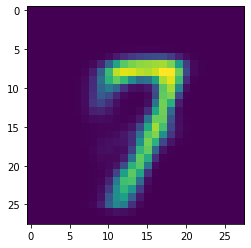

In [217]:
temp_image = generate_images(7)
plt.imshow(temp_image[2])
plt.show()

## Classifier Part

In [7]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [8]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, 10)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.log_softmax(h)
        return out

model = Model()
model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
model.train()

losses = []
for epoch in range(15):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.data)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data), 
                end='')
            
    print()

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 Train Epoch: 0 [57664/60000 (96%)]	Loss: 0.129184
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 0.102641
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 0.079456
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 0.039955
 Train Epoch: 4 [57664/60000 (96%)]	Loss: 0.048989
 Train Epoch: 5 [57664/60000 (96%)]	Loss: 0.059902
 Train Epoch: 6 [57664/60000 (96%)]	Loss: 0.052282
 Train Epoch: 7 [57664/60000 (96%)]	Loss: 0.087476
 Train Epoch: 8 [57664/60000 (96%)]	Loss: 0.048985
 Train Epoch: 9 [57664/60000 (96%)]	Loss: 0.138384
 Train Epoch: 10 [57664/60000 (96%)]	Loss: 0.123397
 Train Epoch: 11 [57664/60000 (96%)]	Loss: 0.073971
 Train Epoch: 12 [57664/60000 (96%)]	Loss: 0.059660
 Train Epoch: 13 [57664/60000 (96%)]	Loss: 0.025509
 Train Epoch: 14 [57664/60000 (96%)]	Loss: 0.045962


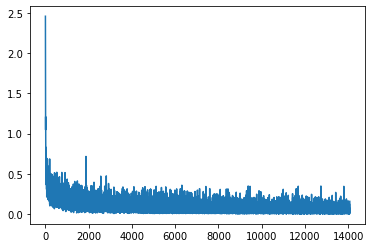

In [11]:
plot(losses)

In [12]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = np.asscalar(d.sum().cpu().detach().numpy().astype(np.float))/d.size()[0]

print('Accuracy:', accuracy)

Accuracy: 0.9755


/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


In [183]:
evaluate_x = torch.from_numpy(image).float().to('cpu') 

In [184]:
output = model(evaluate_x.cuda())

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [185]:
pred = output.data.max(1)[1]

- Write a procedure that:
   1. Generate the Images of each class (hence first looping scructure of i from 0 to 9)
   2. Input each result in the neural network and generate classification)
   3. Concatenate all the results
   

In [283]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 500
TEST_FREQUENCY = 5



train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_params = {"lr": 0.003}
optimizer = Adam(adam_params)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    
    train_elbo.append(-total_epoch_loss_train)
    
    # --------------------------- VAE Testing Sequence ------------------------------

    test_loss = 0.
        # compute the loss over the entire test set
    for x_test,y_test in test_loader:
            # compute ELBO estimate and accumulate loss
            labels_y_test = torch.tensor(np.zeros((y_test.shape[0],2)))
            y_test_2=torch.Tensor.cpu(y_test.reshape(1,y_test.size()[0])[0]).numpy().astype(int)  
            labels_y_test=np.eye(10)[y_test_2]
            labels_y_test = torch.from_numpy(labels_y_test)
        
            test_loss += svi.evaluate_loss(x_test.reshape(-1,784),labels_y_test.float()) 
            
            
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    
    
    #-------------------------- CNN Validation Procedure -----------------------------
    
    all_generated_images_data = np.zeros((1,28,28))
    all_generated_images_labels = np.zeros((1))
    temp_labels = np.zeros((100))
    for j in range (0,10):
        temp_labels[:] = j
        generated_data=generate_images(j)
        all_generated_images_data=np.concatenate((all_generated_images_data,generated_data[:,:]),axis=0)
        all_generated_images_labels=np.concatenate((all_generated_images_labels,temp_labels),axis=0)
    
    evaluate_x=torch.from_numpy(all_generated_images_data).float().to('cpu')
    
    output = model(evaluate_x.cuda())
    
    pred = output.data.max(1)[1]
    
    y_pred=pred[1:1001].cpu().detach().numpy().astype(np.float)
    
    y_class=all_generated_images_labels[1:1001]
    
    classification_accuracy_score = accuracy_score(y_class, y_pred)
    
    print("[epoch %03d]  average training loss: %.4f average testing loss: %.4f Classification Accuracy: %.4f" % (epoch, total_epoch_loss_train,total_epoch_loss_test,classification_accuracy_score))
    
    
    

[epoch 000]  average training loss: 164.3112 average testing loss: 132.3595 Classification Accuracy: 0.7070


/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[epoch 001]  average training loss: 126.0701 average testing loss: 120.7438 Classification Accuracy: 0.8030
[epoch 002]  average training loss: 118.9444 average testing loss: 116.8044 Classification Accuracy: 0.8640
[epoch 003]  average training loss: 115.2021 average testing loss: 114.0697 Classification Accuracy: 0.9070
[epoch 004]  average training loss: 112.8356 average testing loss: 111.4765 Classification Accuracy: 0.9320
[epoch 005]  average training loss: 111.2251 average testing loss: 110.1591 Classification Accuracy: 0.9390
[epoch 006]  average training loss: 109.8835 average testing loss: 108.9575 Classification Accuracy: 0.9540
[epoch 007]  average training loss: 108.9108 average testing loss: 108.4142 Classification Accuracy: 0.9700
[epoch 008]  average training loss: 108.1024 average testing loss: 107.7121 Classification Accuracy: 0.9750
[epoch 009]  average training loss: 107.3393 average testing loss: 106.8514 Classification Accuracy: 0.9750
[epoch 010]  average trainin